In [2]:
import os 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Read data

In [3]:
def read_ml_small():
    data_dir = './ml-100k/ratings.csv'
    data = pd.read_csv(data_dir)
    num_users = data.userId.unique().shape[0]
    num_items = data.movieId.unique().shape[0]
    
    return data, num_users, num_items

# Statistics of the Dataset

In [4]:
data, num_users, num_items = read_ml_small()
sparsity = 1 - len(data) / (num_users * num_items) # 데이터에서 rating이 빈 것의 비율(행렬 만들었을 때)

print(f'유저수 : {num_users}') 
print(f'영화수 : {num_items}')
print(f'matrix sparsity : {sparsity}')
print(data.sample(5))

유저수 : 610
영화수 : 9724
matrix sparsity : 0.9830003169443864
       userId  movieId  rating   timestamp
69276     448     3984     3.5  1173560541
93337     599     2193     3.5  1519138694
92899     599      719     3.0  1498525383
81663     517     1947     1.5  1487953989
15994     104     1088     3.0  1048590956


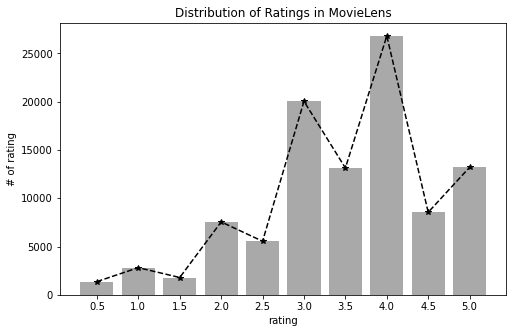

In [5]:
# count rating barchart
rating_cnt = data.rating.value_counts().sort_index()

fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.plot(rating_cnt, 
       color = 'black',
       marker = '*',
       linestyle = '--')
ax.bar(rating_cnt.index, rating_cnt, 
       color = 'darkgray',
       width = 0.4)

ax.set_title('Distribution of Ratings in MovieLens')
ax.set_xlabel('rating')
ax.set_ylabel('# of rating')
ax.set_xticks(rating_cnt.index)
plt.show()

# Label Encoding

In [6]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['userId'].values)
data['item_id_idx'] = item_le.fit_transform(data['movieId'].values)

In [9]:
data.head(5)

,userId,movieId,rating,timestamp,user_id_idx,item_id_idx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


# set Dataset

In [21]:
from torch.utils.data import Dataset

class MovielensDataset(Dataset):
    """MovieLens dataset"""
    
    def __init__(self,data, train = False, test_ratio = 0.1):
        self.data = data
        self.train = train
        self.test_ratio = test_ratio
        self.num_items = len(self.data['item_id_idx'].unique())
        self.num_users = len(self.data['user_id_idx'].unique())
        # split data
        self.train_data, self.test_data = self.split_train_test_data(self.data,
                                                                     test_ratio)
        
        # train/test confirmed
        if self.train == True:
            self.data = self.train_data
        else:
            self.data = self.test_data
            
        # set user, item, rating    
        self.users = torch.tensor(self.data['user_id_idx'].values) 
        self.items = torch.tensor(self.data['item_id_idx'].values)
        self.ratings = torch.tensor(self.data['rating'].values) 
        
        # set matrix
        self.matrix = self.make_matrix()
        
    def make_matrix(self):
        """
        matrix[item][user] = rating 형태로 반환
        In AutoRec, instead of explicitly embedding users/items into low-dimensional space, 
        it uses the column/row of the interaction matrix as the input, 
        then reconstructs the interaction matrix in the output layer.
        unknown ratings are set to zeros by default
        """
        matrix = np.zeros((self.num_items, self.num_users))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            matrix[item][user] = rating
        return matrix
    
    def split_train_test_data(self, data, test_ratio = 0.1):
        """
        train_test_split(data test_size train_size, stratify = self.df['user_id_idx'].values)로 대체 가능
        stratify -> Label별 sampling 
        """
        user_id_uniq = self.data.userId.unique()
        mask = []
        for i in user_id_uniq:
            data_user = self.data[self.data['userId'] == i]
            mask.extend([True if x==1 else False for x in np.random.uniform(0,1,len(data_user))<1-test_ratio])
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
        return train_data, test_data
    
    def __len__(self):
        return len(self.matrix)
    
    def __getitem__(self,idx):
        return torch.tensor(self.matrix[idx]).float()
        

# Model (AutoRec)

In [32]:
from torch import nn
from torch.nn import Module

class AutoRec(Module):
    """
    AutoRec
    AutoRec focuses on learning/reconstructing the output layer. 
    It uses a partially observed interaction matrix as the input, 
    aiming to reconstruct a completed rating matrix. 
    In the meantime, the missing entries of the input 
    are filled in the output layer via reconstruction for the purpose of recommendation.
    """
    
    def __init__(self, num_hidden, num_users, dropout = 0.05):
        super(AutoRec,self).__init__()
        # set latent matrix shape
        self.encoder = nn.Sequential(
            nn.Linear(num_users, num_hidden),
            nn.Sigmoid(),
            nn.Linear(num_hidden, num_hidden)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, num_hidden),
            nn.Sigmoid(),
            nn.Linear(num_hidden, num_users)
            )
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, mat):
        hidden = self.encoder(mat)
        pred = self.decoder(hidden)
        
        return pred

# Train & evaluation function

In [33]:
def train(model, trian_iter, loss, optm, device):
    model.train()
    loss_sum = 0
    
    for matrix in trian_iter:
        matrix = matrix.to(device)
        
        preds = model(matrix)
        loss_out = loss(preds, matrix)
        
        # update
        optm.zero_grad()
        loss_out.backward()
        optm.step()
        
        loss_sum += loss_out.item()
    
    loss_avg = loss_sum/len(trian_iter)
    
    return loss_avg

In [34]:
def evaluate(model, test_iter, device):    
    with torch.no_grad():
        model.eval()
        loss = nn.MSELoss()
        loss_sum = 0
        
        for matrix in test_iter:
            matrix = matrix.to(device)

            preds = model(matrix)
            loss_out = loss(preds, matrix)
            
            loss_sum += loss_out.item()

    loss_avg = loss_sum / len(test_iter)
    
    return loss_avg

# Let's go

In [35]:
# 파라미터 설정

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # device 설정

num_hidden = 10 # Latent factor 수
batch_size = 128 # 배치사이즈
epochs = 31 # 에포크 수
lr = 0.005 # 학습률

device

device(type='cuda')

In [36]:
from torch.utils.data import DataLoader

# train/test data 불러오기 by Dataset&Dataloader
train_dataset = MovielensDataset(data = data, train = True)
test_dataset = MovielensDataset(data = data, train = False)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [37]:
# 모델 객체 생성 
model = AutoRec(num_hidden, num_users).to(device)
loss = nn.MSELoss() # loss 객체
optm = torch.optim.Adam(model.parameters(), lr = lr) # optimizer 객체

epoch: 0, train Loss: 0.2052, test Loss: 0.0302
epoch: 5, train Loss: 0.1638, test Loss: 0.0233
epoch: 10, train Loss: 0.1542, test Loss: 0.0226
epoch: 15, train Loss: 0.1489, test Loss: 0.0225
epoch: 20, train Loss: 0.1465, test Loss: 0.0225
epoch: 25, train Loss: 0.1452, test Loss: 0.0228
epoch: 30, train Loss: 0.1442, test Loss: 0.0225


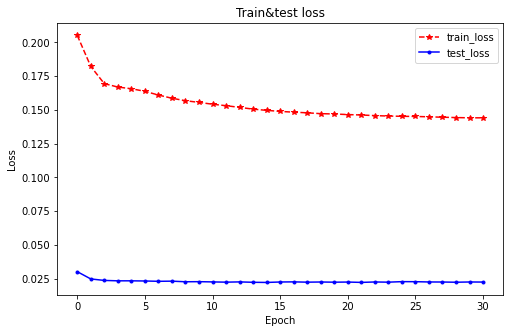

In [38]:
# 학습
train_losses = []
test_losses = []

for epoch in range(epochs):

    train_loss = train(model, train_loader, loss, optm, device)
    test_loss = evaluate(model, test_loader, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if epoch%5==0:
        print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {test_loss:.4f}')

        
# 그래프
fig, ax = plt.subplots(1,1, figsize = (8,5))

ax.plot(train_losses, label = 'train_loss',
       color = 'red',
       marker = '*',
       linestyle = '--')
ax.plot(test_losses, label = 'test_loss',
       color = 'blue',
       marker = '.')

ax.set_title('Train&test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()